In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import pydicom
from sklearn.metrics import f1_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,RandomRotation,\
RandomFlip,RandomTranslation,RandomContrast,RandomZoom
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('../input/merge-labels-and-paths/merge_labels_and_paths.csv')
df.drop(['files_num'],axis=1,inplace=True)
df.head()

,BraTS21ID,MGMT_value,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,0,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,0,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,5,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,6,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [4]:
def load_images(list_paths):
    images=[]
    for path in list_paths:
        img=pydicom.dcmread(path)
        img=img_to_array(img.pixel_array)
        img=tf.image.resize(img,(256,256))
        img=tf.image.central_crop(img, central_fraction=0.7)
        img=tf.image.adjust_contrast(img, contrast_factor=1)
        images.append(img)
    return images

In [6]:
flair_images=load_images(df['best_flair_images'])
t1w_images=load_images(df['best_t1w_images'])
t1wce_images=load_images(df['best_t1wce_images'])
t2w_images=load_images(df['best_t2w_images'])

In [7]:
labels=df['MGMT_value']
labels = labels.astype(np.int8)
print(labels.shape)

(582,)


1
1
0
1
1
1
0
1
1
1


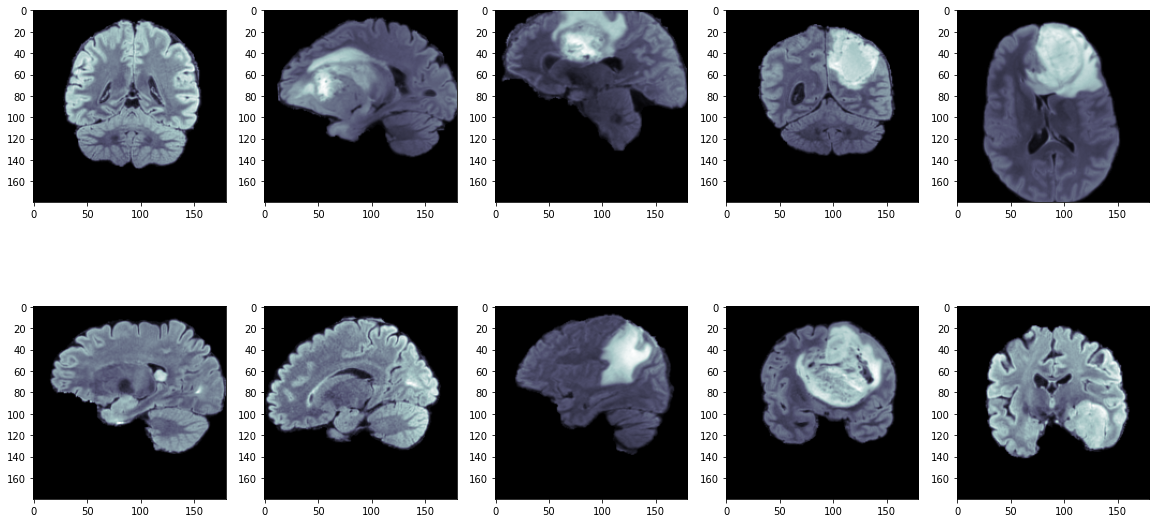

In [7]:
labs=np.array(labels)
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    print(labels[i])
    plt.imshow(flair_images[i],cmap=plt.cm.bone)


In [8]:
len(flair_images)

582

In [ ]:
# img_gen = ImageDataGenerator(
#     zoom_range=0.3,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True)

# dsg = tf.data.Dataset.from_generator(
#     lambda :img_gen.flow(flair_images,y=labels,shuffle=False,batch_size=1), 
#     output_types=(tf.float32,tf.int32),
#     output_shapes=([1,256,256,1],[1])
# )

In [11]:
def prepare_train_val_test_input_pipelines(images,labels):
    AUTOTUNE=tf.data.AUTOTUNE
    
    ds=tf.data.Dataset.from_tensor_slices((images,labels)).shuffle(580)
    size=len(ds)
    #train_set
    train_ds=ds.take(int(size*0.7))
    test_val_ds=ds.skip(int(size*0.7))
    #validation_set
    val_ds=test_val_ds.take(int(0.5*len(test_val_ds)))
    #test_set
    test_ds=test_val_ds.skip(int(0.5*len(test_val_ds)))
    #input_pipelines
    train_ds=train_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
    val_ds=val_ds.map(lambda x,y:(x/256,y)).shuffle(50).batch(1).cache().prefetch(AUTOTUNE)
    test_ds=test_ds.map(lambda x,y:(x/256,y)).batch(1).cache().prefetch(AUTOTUNE)
    
    return train_ds,val_ds,test_ds

In [ ]:
# def prepare_train_val_test_input_pipelines_aug(images,labels):
#     AUTOTUNE=tf.data.AUTOTUNE
#     size=len(images)
    
#     img_gen = ImageDataGenerator(
#         zoom_range=0.3,
#         rotation_range=15,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=True,
#         validation_split=0.2)
#     #train_set
#     train_ds = tf.data.Dataset.from_generator(
#         lambda :img_gen.flow(images[:int(0.8*size)],y=labels[:int(0.8*size)],shuffle=False,batch_size=1,subset='training'), 
#         output_types=(tf.float32,tf.int32),
#         output_shapes=([1,256,256,1],[1])
#         )
#     #validation_set
#     val_ds=tf.data.Dataset.from_generator(
#         lambda :img_gen.flow(images[:int(0.8*size)],y=labels[:int(0.8*size)],shuffle=False,batch_size=1,subset='validation'), 
#         output_types=(tf.float32,tf.int32),
#         output_shapes=([1,256,256,1],[1])
#         )
#     #test_set
#     test_ds=tf.data.Dataset.from_tensor_slices((images[int(0.8*size):],labels[int(0.8*size):]))
#     #input_pipelines
#     train_ds=train_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
#     val_ds=val_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
#     test_ds=test_ds.map(lambda x,y:(x/256,y)).batch(1).cache().prefetch(AUTOTUNE)
    
#     return train_ds,val_ds,test_ds

In [8]:
def train(train_ds,val_ds,epochs=20):
    print('preparing...')
    cnn=Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(180,180,1)),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.5),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.7),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.7),
        Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.5),
        Flatten(),
        Dense(1,activation='sigmoid')
    ])
    print('compiling...')
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    print('training...')
    cnn.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=2)
    print('end training...')
    return cnn

In [9]:
def score(model,test_ds):
    y_pred=[np.int(np.round(i)) for i in model.predict(test_ds)]
    y_true=[]
    for im,y in test_ds:
        y_true.append(y)
    y_true=np.array(y_true)
    score=f1_score(y_true,y_pred)
    print(classification_report(y_true,y_pred))
    return score

In [22]:
def final_prediction(test_flair,test_t1w,test_t1wce,test_t2w,models):
    y_flair_pred=models['flair_cnn'].predict(test_flair)
    y_t1w_pred=models['t1w_cnn'].predict(test_t1w)
    y_t1wce_pred=models['t1wce_cnn'].predict(test_t1wce)
    y_t2w_pred=models['t2w_cnn'].predict(test_t1w)
    sum_y=[y_flair_pred[i] + y_t1w_pred[i] + y_t1wce_pred[i] + y_t2w_pred[i] for i in range(len(y_flair_pred)) ]
    y_pred=[np.int(np.round(i/4)) for i in sum_y]
    return y_pred

In [12]:
train_flair_ds,val_flair_ds,test_flair_ds=prepare_train_val_test_input_pipelines(flair_images,labels)

In [14]:
flair_cnn=train(train_flair_ds,val_flair_ds)

preparing...
compiling...
training...
Epoch 1/20
407/407 - 3s - loss: 2.4862 - accuracy: 0.5233 - val_loss: 0.6931 - val_accuracy: 0.4713
Epoch 2/20
407/407 - 2s - loss: 0.6951 - accuracy: 0.5356 - val_loss: 0.6933 - val_accuracy: 0.4713
Epoch 3/20
407/407 - 2s - loss: 0.7040 - accuracy: 0.5405 - val_loss: 0.6931 - val_accuracy: 0.4943
Epoch 4/20
407/407 - 3s - loss: 0.6900 - accuracy: 0.5749 - val_loss: 0.6785 - val_accuracy: 0.5517
Epoch 5/20
407/407 - 3s - loss: 0.6474 - accuracy: 0.5995 - val_loss: 0.6651 - val_accuracy: 0.5517
Epoch 6/20
407/407 - 2s - loss: 0.6652 - accuracy: 0.6216 - val_loss: 0.6568 - val_accuracy: 0.6322
Epoch 7/20
407/407 - 3s - loss: 0.6130 - accuracy: 0.6732 - val_loss: 0.6521 - val_accuracy: 0.6437
Epoch 8/20
407/407 - 3s - loss: 0.6789 - accuracy: 0.7715 - val_loss: 0.6860 - val_accuracy: 0.5862
Epoch 9/20
407/407 - 3s - loss: 0.5121 - accuracy: 0.7617 - val_loss: 0.5692 - val_accuracy: 0.6897
Epoch 10/20
407/407 - 3s - loss: 0.4424 - accuracy: 0.8280 - v

In [15]:
score(flair_cnn,test_flair_ds)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        41
           1       0.91      0.85      0.88        47

    accuracy                           0.88        88
   macro avg       0.88      0.88      0.87        88
weighted avg       0.88      0.88      0.88        88



0.8791208791208791

In [18]:
train_t1w_ds,val_t1w_ds,test_t1w_ds=prepare_train_val_test_input_pipelines(t1w_images,labels)
t1w_cnn=train(train_t1w_ds,val_t1w_ds,30)
score(t1w_cnn,test_t1w_ds)

preparing...
compiling...
training...
Epoch 1/30
407/407 - 3s - loss: 9.1111 - accuracy: 0.5209 - val_loss: 0.6926 - val_accuracy: 0.5287
Epoch 2/30
407/407 - 2s - loss: 0.7314 - accuracy: 0.5627 - val_loss: 0.6928 - val_accuracy: 0.5287
Epoch 3/30
407/407 - 2s - loss: 0.7260 - accuracy: 0.5233 - val_loss: 0.6928 - val_accuracy: 0.5287
Epoch 4/30
407/407 - 3s - loss: 0.7358 - accuracy: 0.4914 - val_loss: 0.6926 - val_accuracy: 0.5287
Epoch 5/30
407/407 - 3s - loss: 0.6890 - accuracy: 0.5307 - val_loss: 0.6927 - val_accuracy: 0.5287
Epoch 6/30
407/407 - 3s - loss: 0.7056 - accuracy: 0.5061 - val_loss: 0.6851 - val_accuracy: 0.5632
Epoch 7/30
407/407 - 2s - loss: 0.6887 - accuracy: 0.5577 - val_loss: 0.6928 - val_accuracy: 0.5172
Epoch 8/30
407/407 - 3s - loss: 0.6839 - accuracy: 0.6265 - val_loss: 0.6892 - val_accuracy: 0.5632
Epoch 9/30
407/407 - 3s - loss: 0.6454 - accuracy: 0.6118 - val_loss: 0.6480 - val_accuracy: 0.6897
Epoch 10/30
407/407 - 2s - loss: 0.6130 - accuracy: 0.6609 - v

0.8349514563106796

In [19]:
train_t1wce_ds,val_t1wce_ds,test_t1wce_ds=prepare_train_val_test_input_pipelines(t1wce_images,labels)
t1wce_cnn=train(train_t1wce_ds,val_t1wce_ds,30)
print('scoring :',score(t1wce_cnn,test_t1wce_ds))

preparing...
compiling...
training...
Epoch 1/30
407/407 - 3s - loss: 24.7337 - accuracy: 0.4840 - val_loss: 0.6950 - val_accuracy: 0.4253
Epoch 2/30
407/407 - 3s - loss: 0.8507 - accuracy: 0.5283 - val_loss: 0.6954 - val_accuracy: 0.4253
Epoch 3/30
407/407 - 2s - loss: 0.7277 - accuracy: 0.5307 - val_loss: 0.6956 - val_accuracy: 0.4253
Epoch 4/30
407/407 - 2s - loss: 0.7014 - accuracy: 0.5651 - val_loss: 0.6964 - val_accuracy: 0.4253
Epoch 5/30
407/407 - 3s - loss: 0.6701 - accuracy: 0.5823 - val_loss: 0.6957 - val_accuracy: 0.4368
Epoch 6/30
407/407 - 2s - loss: 0.6636 - accuracy: 0.6020 - val_loss: 0.6968 - val_accuracy: 0.4253
Epoch 7/30
407/407 - 3s - loss: 0.6497 - accuracy: 0.6290 - val_loss: 0.6970 - val_accuracy: 0.4368
Epoch 8/30
407/407 - 3s - loss: 0.6248 - accuracy: 0.6290 - val_loss: 0.6945 - val_accuracy: 0.4483
Epoch 9/30
407/407 - 3s - loss: 0.5615 - accuracy: 0.6806 - val_loss: 0.6751 - val_accuracy: 0.6092
Epoch 10/30
407/407 - 3s - loss: 0.5273 - accuracy: 0.7174 - 

In [20]:
train_t2w_ds,val_t2w_ds,test_t2w_ds=prepare_train_val_test_input_pipelines(t2w_images,labels)
t2w_cnn=train(train_t2w_ds,val_t2w_ds)
print('scoring :',score(t2w_cnn,test_t2w_ds))

preparing...
compiling...
training...
Epoch 1/20
407/407 - 3s - loss: 6.7844 - accuracy: 0.5455 - val_loss: 0.6936 - val_accuracy: 0.4713
Epoch 2/20
407/407 - 2s - loss: 0.6749 - accuracy: 0.6093 - val_loss: 0.6936 - val_accuracy: 0.4713
Epoch 3/20
407/407 - 3s - loss: 0.6800 - accuracy: 0.5700 - val_loss: 0.6937 - val_accuracy: 0.4713
Epoch 4/20
407/407 - 3s - loss: 0.6934 - accuracy: 0.5971 - val_loss: 0.6941 - val_accuracy: 0.4713
Epoch 5/20
407/407 - 3s - loss: 0.6994 - accuracy: 0.6044 - val_loss: 0.6944 - val_accuracy: 0.4713
Epoch 6/20
407/407 - 2s - loss: 0.6985 - accuracy: 0.5921 - val_loss: 0.6949 - val_accuracy: 0.4828
Epoch 7/20
407/407 - 2s - loss: 0.6502 - accuracy: 0.5897 - val_loss: 0.6878 - val_accuracy: 0.5287
Epoch 8/20
407/407 - 2s - loss: 0.6036 - accuracy: 0.6658 - val_loss: 0.6766 - val_accuracy: 0.5632
Epoch 9/20
407/407 - 2s - loss: 0.5903 - accuracy: 0.6732 - val_loss: 0.6593 - val_accuracy: 0.5977
Epoch 10/20
407/407 - 3s - loss: 0.5147 - accuracy: 0.7076 - v

In [23]:
models={'flair_cnn':flair_cnn,'t1w_cnn':t1w_cnn,'t1wce_cnn':t1wce_cnn,'t2w_cnn':t2w_cnn}

In [24]:
y_pred=final_prediction(test_flair_ds,test_t1w_ds,test_t1wce_ds,test_t2w_ds,models)

In [25]:
y_true=[]
for im,y in test_flair_ds:
    y_true.append(y)
y_true=np.array(y_true)
score=f1_score(y_true,y_pred)
score

0.7142857142857144

In [26]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        41
           1       0.69      0.74      0.71        47

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



In [27]:
sample_submission_df=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
sample_submission_df.head()

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5


In [28]:
def bytes_to_str(byte_filename):
    return str(byte_filename).split('\'')[1]

In [29]:
def best_image(ds_paths):
    
    s=0
    filep=''
    for filename in ds_paths.as_numpy_iterator():
        img=pydicom.dcmread(bytes_to_str(filename))
        sp=np.array(img.pixel_array).sum()
        if(sp>s):
            s=sp
            filep=bytes_to_str(filename)
    #best_img=pydicom.dcmread(filep)
    return filep

In [30]:
def image_selection(test_ds_files):
    files_num=[]
    best_flair_images=[]
    best_t1w_images=[]
    best_t1wce_images=[]
    best_t2w_images=[]
    for filename in test_ds_files.as_numpy_iterator():
        path=bytes_to_str(filename)
        FLAIR_PATH=path+'/FLAIR/*'
        T1w_PATH=path+'/T1w/*'
        T1wCE_PATH=path+'/T1wCE/*'
        T2w_PATH=path+'/T2w/*'
        ds_files_FLAIR=tf.data.Dataset.list_files(FLAIR_PATH,)
        ds_files_T1w=tf.data.Dataset.list_files(T1w_PATH)
        ds_files_T1wCE=tf.data.Dataset.list_files(T1wCE_PATH)
        ds_files_T2w=tf.data.Dataset.list_files(T2w_PATH)
        file_num=path.split('/')[-1]
        files_num.append(int(file_num))
        best_flair_images.append(best_image(ds_files_FLAIR))
        best_t1w_images.append(best_image(ds_files_T1w))
        best_t1wce_images.append(best_image(ds_files_T1wCE))
        best_t2w_images.append(best_image(ds_files_T2w))
    return files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images

In [ ]:
#ds_test_files=tf.data.Dataset.list_files('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/*')
#files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images=image_selection(ds_test_files.batch(1))

In [ ]:
# dict={
#     'files_num':files_num,
#     'best_flair_images':best_flair_images,
#     'best_t1w_images':best_t1w_images,
#     'best_t1wce_images':best_t1wce_images,
#     'best_t2w_images':best_t2w_images
# }
# df=pd.DataFrame(dict)
# df.head()
# df.to_csv('test_best_images_paths.csv',index=False)

In [33]:
test_best_images_paths=pd.read_csv('../input/test-best-images-paths/test_best_images_paths.csv')
test_best_images_paths.head()

,files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,702,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,573,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,307,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,229,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,712,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


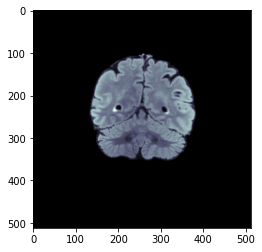

In [34]:
ds = pydicom.dcmread(test_best_images_paths['best_flair_images'][0])
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

In [35]:
ds=pd.merge(sample_submission_df,test_best_images_paths,left_on=['BraTS21ID'],right_on=['files_num'])
ds.head()

,BraTS21ID,MGMT_value,files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,1,0.5,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,13,0.5,13,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,15,0.5,15,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,27,0.5,27,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,37,0.5,37,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [36]:
ds=ds.dropna(axis=0)
ds.drop(['files_num'],axis=1,inplace=True)
ds.to_csv('test_merge_labels_and_paths.csv',index=False)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 86
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BraTS21ID          87 non-null     int64  
 1   MGMT_value         87 non-null     float64
 2   best_flair_images  87 non-null     object 
 3   best_t1w_images    87 non-null     object 
 4   best_t1wce_images  87 non-null     object 
 5   best_t2w_images    87 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [37]:
sub_flair_images=load_images(ds['best_flair_images'])
sub_t1w_images=load_images(ds['best_t1w_images'])
sub_t1wce_images=load_images(ds['best_t1wce_images'])
sub_t2w_images=load_images(ds['best_t2w_images'])

In [39]:
def prepare_submission_input_pipeline(images):
    AUTOTUNE=tf.data.AUTOTUNE
    test_ds=tf.data.Dataset.from_tensor_slices(images)
    test_ds=test_ds.map(lambda x:x/256).batch(1).cache().prefetch(AUTOTUNE)
    return test_ds

In [40]:
submission_pipeline_flair=prepare_submission_input_pipeline(sub_flair_images)
submission_pipeline_t1w=prepare_submission_input_pipeline(sub_t1w_images)
submission_pipeline_t1wce=prepare_submission_input_pipeline(sub_t1wce_images)
submission_pipeline_t2w=prepare_submission_input_pipeline(sub_t2w_images)

In [41]:
y_pred_submittion=final_prediction(submission_pipeline_flair,submission_pipeline_t1w,\
                                   submission_pipeline_t1wce,submission_pipeline_t2w,models)

In [42]:
sample_submission_df['MGMT_value']=y_pred_submittion

In [43]:
sample_submission_df.to_csv('submission.csv',index=False)

In [44]:
sample_submission_df.head()

,BraTS21ID,MGMT_value
0,1,1
1,13,0
2,15,0
3,27,0
4,37,0
